In [1]:
from math import sin, pi
import torch
import intel_extension_for_pytorch as ipex

torch.set_default_device("xpu")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
xs = torch.arange(0.0, 2. * pi, 1. / 64.)
ys = torch.tensor([sin(x.item()) for x in xs])

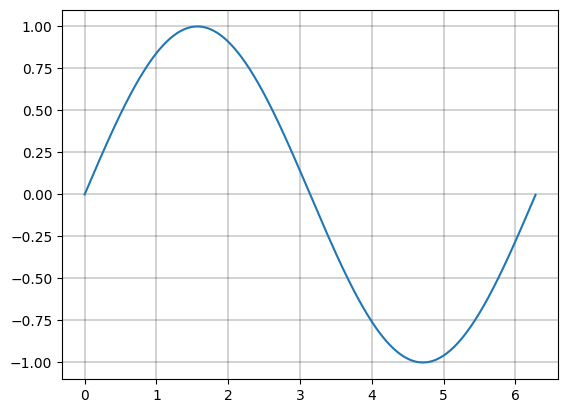

In [3]:
# Plot real valuues of sin(x)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(xs.to("cpu")), list(ys.to("cpu")))
plt.grid(visible=True, which='major', axis='both', color='black', linestyle='-', linewidth=0.25)

In [4]:
PARAM_COUNT = 4

In [5]:
xenc = torch.tensor([[xx ** ix for ix in range(PARAM_COUNT)] for xx in xs])

In [6]:
class SinModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.NN = torch.nn.Parameter(torch.randn(size=(PARAM_COUNT,), dtype=torch.float32, requires_grad=True))

    def forward(self, input):
        return input @ self.NN

model = SinModel()
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-7)

for t in range(20000):
    y_pred = model(xenc)
    loss = criterion(y_pred, ys)

    if t % 100 == 99:
        print(t, loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        

99 6717.08740234375
199 5768.79736328125
299 4969.9462890625
399 4296.9033203125
499 3729.772705078125
599 3251.81494140625
699 2848.926513671875
799 2509.236328125
899 2222.75439453125
999 1981.069580078125
1099 1777.0989990234375
1199 1604.8817138671875
1299 1459.3984375
1399 1336.4224853515625
1499 1232.3968505859375
1599 1144.3294677734375
1699 1069.69775390625
1799 1006.3790283203125
1899 952.587158203125
1999 906.8173828125
2099 867.8046264648438
2199 834.4814453125
2299 805.9505615234375
2399 781.4571533203125
2499 760.3643798828125
2599 742.1368408203125
2699 726.3239135742188
2799 712.5462646484375
2899 700.4839477539062
2999 689.8680419921875
3099 680.4722900390625
3199 672.1053466796875
3299 664.6072387695312
3399 657.8428344726562
3499 651.697998046875
3599 646.077392578125
3699 640.9000244140625
3799 636.097900390625
3899 631.6139526367188
3999 627.3999633789062
4099 623.41552734375
4199 619.6263427734375
4299 616.0037841796875
4399 612.5234375
4499 609.1650390625
4599 605

In [7]:
def train_on_intel():
    model = SinModel()
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-7)
    model, optimizer = ipex.optimize(model, optimizer=optimizer)
    
    for t in range(200000):
        y_pred = model(xenc)
        loss = criterion(y_pred, ys)
    
        if t % 100 == 99:
            print(t, loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
train_on_intel()

99 102.98446655273438
199 99.98184967041016
299 97.44381713867188
399 95.29698181152344
499 93.4794692993164
599 91.93925476074219
699 90.63249969482422
799 89.52235412597656
899 88.57768249511719
999 87.77244567871094
1099 87.08456420898438
1199 86.49551391601562
1299 85.98966979980469
1399 85.55397033691406
1499 85.17728424072266
1599 84.85035705566406
1699 84.56536865234375
1799 84.31562042236328
1899 84.09566497802734
1999 83.9007568359375
2099 83.72703552246094
2199 83.57115173339844
2299 83.4302749633789
2399 83.30207824707031
2499 83.1845474243164
2599 83.0760498046875
2699 82.97525024414062
2799 82.88103485107422
2899 82.79200744628906
2999 82.70787048339844
3099 82.62742614746094
3199 82.55067443847656
3299 82.47628784179688
3399 82.40460205078125
3499 82.33512115478516
3599 82.26693725585938
3699 82.20048522949219
3799 82.1355209350586
3899 82.07184600830078
3999 82.00859069824219
4099 81.94615936279297
4199 81.88457489013672
4299 81.82373809814453
4399 81.7635498046875
4499 

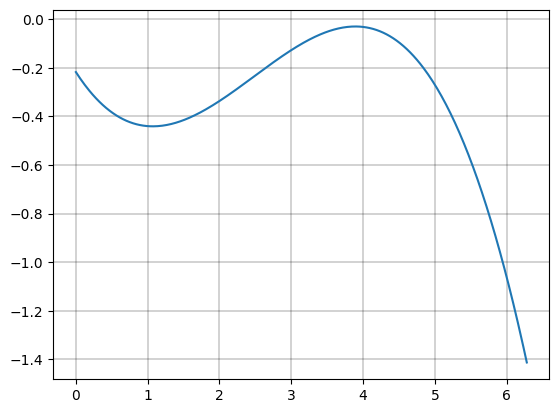

In [8]:
ys_infered = [ x.item() for x in list(model(xenc).to("cpu")) ]

plt.plot(list(xs.to("cpu")), list(ys_infered))
plt.grid(visible=True, which='major', axis='both', color='black', linestyle='-', linewidth=0.25)

In [9]:
a = torch.randn((), dtype=torch.float32, requires_grad=True)
b = torch.randn((), dtype=torch.float32, requires_grad=True)
c = torch.randn((), dtype=torch.float32, requires_grad=True)
d = torch.randn((), dtype=torch.float32, requires_grad=True)

learning_rate = 1e-7

for t in range(200000):

    y_pred = a + b*xs + c*xs**2 + d*xs**3
    
    loss = (y_pred - ys).pow(2).sum()
    if loss.item() < 20.:
        break

    if t % 100 == 99:
        print(t, loss.item())

    a.grad = None
    b.grad = None
    c.grad = None
    d.gard = None
        
    loss.backward()

    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

99 79253.734375
199 4862.9462890625
299 1720.80908203125
399 1413.486328125
499 1204.750732421875
599 1030.5521240234375
699 885.14453125
799 763.4680786132812
899 661.5497436523438
999 576.1544799804688
1099 504.5896911621094
1199 444.6029052734375
1299 394.309326171875
1399 352.1309509277344
1499 316.74627685546875
1599 287.04931640625
1699 262.11419677734375
1799 241.16574096679688
1899 223.55511474609375
1999 208.73892211914062
2099 196.262451171875
2199 185.74517822265625
2299 176.8682403564453
2399 169.36488342285156
2499 163.0118408203125
2599 157.6219482421875
2699 153.03875732421875
2799 149.13124084472656
2899 145.78970336914062
2999 142.92230224609375
3099 140.45216369628906
3199 138.31491088867188
3299 136.4566650390625
3399 134.83230590820312
3499 133.40411376953125
3599 132.14041137695312
3699 131.0147705078125
3799 130.00502014160156
3899 129.09259033203125
3999 128.26199340820312
4099 127.50018310546875
4199 126.79629516601562
4299 126.14118957519531
4399 125.5272521972

In [10]:
print(f'f(x) = {a} + {b}x + {c}x^2 + {d}x^3')

f(x) = 0.6434015035629272 + 0.6498096585273743x + -0.4391617774963379x^2 + 0.05015658214688301x^3


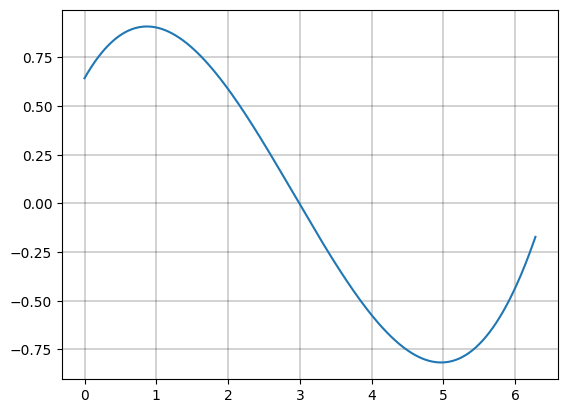

In [11]:
ys_infered = xs.clone().to("cpu")
ys_infered.apply_(lambda x: a + b*x + c*x**2 + d*x**3)

plt.plot(list(xs.to("cpu")), list(ys_infered))
plt.grid(visible=True, which='major', axis='both', color='black', linestyle='-', linewidth=0.25)
plt.show()